In [1]:
# ===========================
# Cell 0 — Config
# ===========================
DATA_ID = 'mackey_glass_tau17_n200'   # your dataset folder name

# Noise used in training & scoring
EVAL_SIGMA   = 0.20

# Windowing (must match qubit count for our QAE)
wind_size    = 4      # == n_qubits
wind_step    = 2

# Train/Test split on windows produced from the full series
split        = 0.75   # first 75% windows → train, last 25% → test

# Runs
INSTANCE_IDS = [1,2,3,4,5]  # random seeds for different runs
LAYER_OPTIONS = [1, 3]  # Stage-1/3 depth options


# Backends to use (you can keep both lightning; 'measure' may fall back from adjoint automatically)
STAGE1_BACKEND = 'lightning.qubit'
STAGE3_BACKEND = 'lightning.qubit'

# Logging
LOG_NAME = 'aintern'
CASE_NAME = 'half_qae'
DATA_PATH = f'{LOG_NAME}/data'
FIGURES_PATH = f'{LOG_NAME}/figures'
TRAIN_PATH = f'{LOG_NAME}/training'
PARAMS_PATH = f'{LOG_NAME}/params'
ANALYSIS_PATH = f'{LOG_NAME}/analysis'

In [2]:
# ===========================
# Cell 1 — Imports & utils
# ===========================
import os, sys, time, math, random, json
from pathlib import Path
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
import matplotlib.pyplot as plt

# repo utils
sys.path.append('.'); sys.path.append('..')
from qae_utils.Files import create_folder_if_needed, read_json_file, read_ts_file
from qae_utils.Window import ts_wind_make, ts_wind_split, ts_wind_flatten_avg
from qae_utils.Window import ts_add_noise
from qae_utils.Charts import multi_plot_flat_ts

# folders
for p in [FIGURES_PATH, TRAIN_PATH, PARAMS_PATH, ANALYSIS_PATH]:
    create_folder_if_needed(p)

# plotting
np.set_printoptions(suppress=True, precision=6)
plt.rcParams["figure.figsize"] = (6.5, 4)

def set_global_seed(instance_id: int):
    base = 10_000 + int(instance_id)
    random.seed(base + 11)
    np.random.seed(base + 22)
    try:
        pnp.random.seed(base + 33)
    except Exception:
        pass
    return dict(global_seed=base, numpy_seed=base+22, pnp_seed=base+33)

Using data folder: aintern/data\mackey_glass_tau17_n200
Loaded 200 samples; scale = [0.200, 0.800]


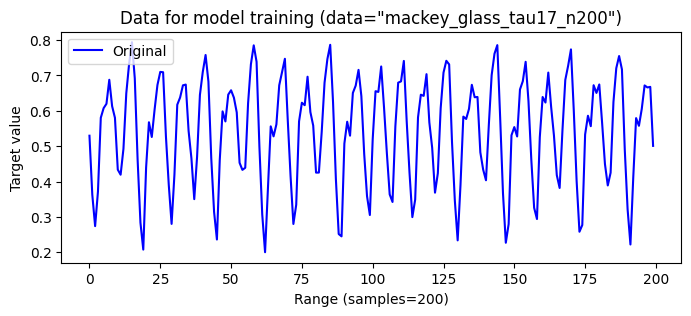

In [3]:
# ===========================
# Cell 2 — Load data & embed (robust paths)
# ===========================
import os

# keep your DATA_ID, LOG_NAME, DATA_PATH from Cell 0
# this resolver tries several roots so relative paths won't break
def _find_data_folder(data_id, log_name='aintern', preferred_root=None):
    candidates = []
    if preferred_root:
        candidates.append(preferred_root)
    # common locations
    candidates += [
        f'./{log_name}/data',
        f'../{log_name}/data',
        f'../../{log_name}/data',
        './jacobs_examples/aintern/data',
        '../jacobs_examples/aintern/data',
        '../../jacobs_examples/aintern/data',
    ]
    tried = []
    for root in candidates:
        folder = os.path.join(root, data_id)
        info_p = os.path.join(folder, 'info.json')
        x_p    = os.path.join(folder, 'x_org.arr')
        y_p    = os.path.join(folder, 'y_org.arr')
        tried.append(folder)
        if os.path.isdir(folder) and all(os.path.exists(p) for p in (info_p, x_p, y_p)):
            return folder
    raise FileNotFoundError(
        "Could not find dataset folder with required files.\n"
        f"DATA_ID='{data_id}'. Tried:\n - " + "\n - ".join(tried)
    )

# resolve the folder (uses your DATA_PATH from Cell 0 as a preference)
try:
    DATA_FOLDER = _find_data_folder(DATA_ID, log_name=LOG_NAME, preferred_root=DATA_PATH)
except Exception as e:
    # last resort: try without preferred_root
    DATA_FOLDER = _find_data_folder(DATA_ID, log_name=LOG_NAME, preferred_root=None)

data_info_path = f'{DATA_FOLDER}/info.json'
x_org_path     = f'{DATA_FOLDER}/x_org.arr'
y_org_path     = f'{DATA_FOLDER}/y_org.arr'

info = read_json_file(data_info_path)
X = read_ts_file(x_org_path).astype(int)  # indices (for plotting only)
y = read_ts_file(y_org_path)              # values (original domain)

scale_low  = float(info['scale_low'])
scale_high = float(info['scale_high'])
print(f'Using data folder: {DATA_FOLDER}')
print(f'Loaded {len(y)} samples; scale = [{scale_low:.3f}, {scale_high:.3f}]')

# quick plot (optional)
multi_plot_flat_ts([y], X_list=[0], colors=['blue'], labels=['Original'],
                   lines=['solid'], legend_cols=1, rcParams=(8, 3),
                   xlabel=f'Range (samples={len(y)})',
                   title=f'Data for model training (data=\"{DATA_ID}\")')

def embed_input(x, wires=None, info_=None):
    if info_ is None: info_ = info
    lo, hi = float(info_['scale_low']), float(info_['scale_high'])
    xn = (pnp.array(x) - lo) / max(hi - lo, 1e-12)
    if wires is None:
        wires = range(len(xn))
    for i, v in enumerate(xn):
        qml.RY(v * pnp.pi, wires=wires[i])

In [4]:
# ===========================
# Cell 3 — Architecture (4q, 2 latent, 1 trash)
# ===========================
n_qubits = wind_size      # must equal window size
n_latent = 2
n_trash  = n_qubits - n_latent
trash_wires  = list(range(n_latent, n_qubits))  # [3] for 4q
signal_wires = list(range(n_qubits))            # diagnostics / full outputs


def encoder_ansatz(params, n_layers):
    assert len(params) == n_layers * n_qubits * 3
    for l in range(n_layers):
        for q in range(n_qubits):
            idx = l * n_qubits * 3 + q * 3
            qml.RX(params[idx + 0], wires=q)
            qml.RY(params[idx + 1], wires=q)
            qml.RZ(params[idx + 2], wires=q)
        for q in range(n_qubits - 1):
            qml.CNOT(wires=[q, q + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])

def decoder_ansatz(params, n_layers):
    
    assert len(params) == n_layers * n_qubits * 3
    for l in range(n_layers):
        for q in range(n_qubits - 1):
            qml.CNOT(wires=[q, q + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])
        for q in range(n_qubits):
            idx = l * n_qubits * 3 + q * 3
            qml.RZ(params[idx + 2], wires=q)
            qml.RY(params[idx + 1], wires=q)
            qml.RX(params[idx + 0], wires=q)

def adjoint_decoder_ansatz(params, n_layers):
    assert len(params) == n_layers * n_qubits * 3
    for l in reversed(range(n_layers)):
        for q in reversed(range(n_qubits - 1)):
            qml.CNOT(wires=[q + 1, q])
        qml.CNOT(wires=[n_qubits - 1, 0])
        for q in reversed(range(n_qubits)):
            idx = l * n_qubits * 3 + q * 3
            qml.RX(-params[idx + 0], wires=q)
            qml.RY(-params[idx + 1], wires=q)
            qml.RZ(-params[idx + 2], wires=q)

print(f"Architecture set: {n_qubits}q ({n_latent} latent, {n_trash} trash).")

Architecture set: 4q (2 latent, 2 trash).


In [5]:
# Cell 4 Stage 1 (adjoint decoder swap-test)
trash2_start = n_qubits
ancilla      = n_qubits + n_trash
num_total_s1 = n_qubits + n_trash + 1
dev_s1 = qml.device(STAGE1_BACKEND, wires=num_total_s1, shots=None)

@qml.qnode(dev_s1, interface="autograd", diff_method="best")
def swap_test_on_adj_decoder(x, params, n_layers):
    main   = list(range(n_qubits))
    trash1 = list(range(n_latent, n_latent + n_trash))
    trash2 = list(range(trash2_start, trash2_start + n_trash))

    embed_input(x)
    adjoint_decoder_ansatz(params, n_layers)

    for i in trash2:
        qml.Hadamard(wires=i)
    qml.Hadamard(wires=ancilla)
    for i in range(n_trash):
        qml.CSWAP(wires=[ancilla, trash1[i], trash2[i]])
    qml.Hadamard(wires=ancilla)

    return qml.probs(wires=ancilla)

def s1_cost(params, X_batch, n_layers):
    acc = pnp.array(0.0)
    for x in X_batch:
        p0 = swap_test_on_adj_decoder(x, params, n_layers)[0]
        acc = acc + (1.0 - p0)
    return acc / len(X_batch)

def train_adjoint_decoder(
    windows_train_clean, n_layers, instance_id,
    n_epochs=120, lr_init=0.010, patience=10, lr_patience=8
):
    set_global_seed(instance_id)
    adj_shape = n_layers * n_qubits * 3
    params = pnp.array(np.random.normal(0, 0.5, adj_shape), requires_grad=True)
    opt = qml.AdamOptimizer(stepsize=lr_init)
    lr = lr_init

    best_params, best_val = None, float("inf")
    no_improve = 0

    for ep in range(n_epochs):
        cost = s1_cost(params, windows_train_clean, n_layers)
        params, _ = opt.step_and_cost(lambda p: s1_cost(p, windows_train_clean, n_layers), params)

        if cost < best_val - 1e-9:
            best_val, best_params, no_improve = float(cost), pnp.array(params, requires_grad=False), 0
        else:
            no_improve += 1
            if (no_improve % lr_patience) == 0:
                lr = max(lr * 0.5, 1e-4)
                opt = qml.AdamOptimizer(stepsize=lr)
                print(f"[Stage1] ↓ LR → {lr:.5f}")
            if no_improve >= patience:
                print("[Stage1] Early stopping."); break

        if ep % 5 == 0 or ep == n_epochs-1:
            print(f"[Stage1] L={n_layers} ep {ep:03d} | train {float(cost):.6f} | LR {lr:.5f}")

    return dict(phi=(best_params if best_params is not None else params),
                best_train=float(best_val))

In [6]:
def Z_to_values_autograd(z_all):
    z_all = pnp.clip(pnp.asarray(z_all), -0.999999, 0.999999)
    v01   = pnp.arccos(z_all) / pnp.pi
    return v01 * (scale_high - scale_low) + scale_low

def first_diff(x):
    x = pnp.array(x); return x[1:] - x[:-1]

def p1_from_expZ(z):
    return (1 - pnp.asarray(z)) * 0.5

def huber(residual, delta):
    r = pnp.abs(residual)
    return pnp.where(r <= delta, 0.5*r**2, delta*(r - 0.5*delta))

In [7]:
# ===========================
# Cell 5 — Noise & scoring helpers
# ===========================
def make_windows_from_series(y_vec, noise_sigma, seed, wind_size, wind_step):
    """
    Inject one noise vector into the whole series,
    then windowize both clean and noisy series the same way.
    """
    y_noisy = ts_add_noise(y_vec, noise=noise_sigma, noise_type='normal', clip=False,
                           range_low=scale_low, range_high=scale_high, seed=seed)

    win_clean = ts_wind_make(y_vec,   wind_size, wind_step)
    win_noisy = ts_wind_make(y_noisy, wind_size, wind_step)

    # windows index array (not used by model, only for split helper)
    X_ts = np.array([i*wind_step for i in range(len(win_clean))])

    # split consistently
    X_tr, y_tr_clean, X_te, y_te_clean = ts_wind_split(X_ts, win_clean, split)
    X_tr, y_tr_noisy, X_te, y_te_noisy = ts_wind_split(X_ts, win_noisy, split)

    return (y_tr_clean, y_tr_noisy, y_te_clean, y_te_noisy)

def denoise_windows(params, denoise_qnode, windows_noisy):
    outs = []
    for w in windows_noisy:
        zD = pnp.array(denoise_qnode(params, w))
        outs.append(pnp.array(Z_to_values_autograd(zD)))
    return pnp.stack(outs)

def mse_on_windows(w_true, w_pred):
    w_true = np.asarray(w_true); w_pred = np.asarray(w_pred)
    return float(np.mean((w_true - w_pred)**2))

def mse_on_series_avg(w_true, w_pred, step):
    flat_true = ts_wind_flatten_avg(np.asarray(w_true), step)
    flat_pred = ts_wind_flatten_avg(np.asarray(w_pred), step)
    return float(np.mean((flat_true - flat_pred)**2))

In [8]:
def _series_to_train_test_windows(y_vec, sigma, seed):
    y_noisy = ts_add_noise(
        y_vec, noise=sigma, noise_type='normal', clip=False,
        range_low=scale_low, range_high=scale_high, seed=seed
    )
    win_clean = ts_wind_make(y_vec,   wind_size, wind_step)
    win_noisy = ts_wind_make(y_noisy, wind_size, wind_step)
    X_ts = np.array([i*wind_step for i in range(len(win_clean))])
    _, tr_clean, _, te_clean = ts_wind_split(X_ts, win_clean, split)
    _, tr_noisy, _, te_noisy = ts_wind_split(X_ts, win_noisy, split)
    return np.asarray(tr_clean), np.asarray(tr_noisy), np.asarray(te_clean), np.asarray(te_noisy)

def _win_mse(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.mean((a - b)**2))

def _ser_mse(a, b):
    a = ts_wind_flatten_avg(np.asarray(a), wind_step)
    b = ts_wind_flatten_avg(np.asarray(b), wind_step)
    return float(np.mean((a - b)**2))



In [9]:
# Cell 6 Stage 3 (encoder swap-test latent vs clean ref) --------
dev_s3 = qml.device(STAGE3_BACKEND, wires=2*n_qubits + 1, shots=None)

@qml.qnode(dev_s3, interface="autograd",diff_method="best")
def swap_test_encoder_latent(x_noisy, x_clean, enc_params, dec_dagger_params, n_layers):
    encoder = list(range(n_qubits))
    ref     = list(range(n_qubits, 2*n_qubits))
    anc     = 2*n_qubits

    # Przygotuj stan na rejestrze encoder
    embed_input(x_noisy, wires=encoder)
    encoder_ansatz(enc_params, n_layers)

    # Przygotuj stan na rejestrze ref
    embed_input(x_clean, wires=ref)
    adjoint_decoder_ansatz(dec_dagger_params, n_layers)

    qml.Hadamard(wires=anc)
    for i in range(n_latent):
        qml.CSWAP(wires=[anc, encoder[i], ref[i]])
    qml.Hadamard(wires=anc)
    return qml.probs(wires=anc)

def s3_cost(enc_params, X_noisy_b, X_clean_b, dec_dagger_params, n_layers):
    acc = pnp.array(0.0)
    for xn, xc in zip(X_noisy_b, X_clean_b):
        p0 = swap_test_encoder_latent(xn, xc, enc_params, dec_dagger_params, n_layers)[0]
        acc = acc + (1.0 - p0)
    return acc / len(X_noisy_b)

def train_encoder_with_swaptest_series_noise(
    y_full, dec_dagger_params, n_layers, instance_id,
    EPOCHS=24, INNER_STEPS=6, BATCH_SIZE=64, LR=0.001,
    USE_EMA=True, EMA_DECAY=0.995, CLIP_NORM=1.0,
    TRAIN_SEED_BASE=88000, TEST_SEED_FIXED=99123,
    noise_level=EVAL_SIGMA
):
    set_global_seed(instance_id)
    param_shape = n_layers * n_qubits * 3
    psi = pnp.array(np.random.normal(0, 0.05, param_shape), requires_grad=True)
    opt = qml.AdamOptimizer(stepsize=LR)
    ema = pnp.array(psi, requires_grad=False) if USE_EMA else None

    hist_train_win_mse, hist_test_win_mse = [], []
    hist_train_ser_mse, hist_test_ser_mse = [], []

    def swaptest_cost(params, batch_noisy, batch_clean):
        acc = pnp.array(0.0)
        for xn, xc in zip(batch_noisy, batch_clean):
            p0 = swap_test_encoder_latent(xn, xc, params, dec_dagger_params, n_layers)[0]
            acc = acc + (1.0 - p0)
        return acc / max(len(batch_noisy), 1)

    for ep in range(EPOCHS):
        tr_clean, tr_noisy, te_clean, te_noisy = make_windows_from_series(
            y_full, noise_level, TRAIN_SEED_BASE + ep, wind_size, wind_step
        )

        for _ in range(INNER_STEPS):
            idx = np.random.randint(0, len(tr_clean), size=min(BATCH_SIZE, len(tr_clean)))
            batch_c = [tr_clean[i] for i in idx]
            batch_n = [tr_noisy[i] for i in idx]
            psi, _ = opt.step_and_cost(lambda p: swaptest_cost(p, batch_n, batch_c), psi)
            if USE_EMA:
                ema = EMA_DECAY * ema + (1 - EMA_DECAY) * psi

        eval_params = ema if USE_EMA else psi

        # Ewaluacja na oknach
        train_mse_win = mse_on_windows(tr_clean, tr_noisy)
        test_mse_win  = mse_on_windows(te_clean, te_noisy)
        train_mse_ser = mse_on_series_avg(tr_clean, tr_noisy, wind_step)
        test_mse_ser  = mse_on_series_avg(te_clean, te_noisy, wind_step)

        hist_train_win_mse.append(float(train_mse_win))
        hist_test_win_mse.append(float(test_mse_win))
        hist_train_ser_mse.append(float(train_mse_ser))
        hist_test_ser_mse.append(float(test_mse_ser))

        print(f"[SwapTest] L={n_layers} ep {ep:03d} | "
              f"train MSE(win) {train_mse_win:.5f} | "
              f"test MSE(win) {test_mse_win:.5f} | "
              f"test MSE(series) {test_mse_ser:.5f}")

    return dict(
        psi=(ema if USE_EMA else psi),
        hist_train_win_mse=hist_train_win_mse,
        hist_test_win_mse=hist_test_win_mse,
        hist_train_ser_mse=hist_train_ser_mse,
        hist_test_ser_mse=hist_test_ser_mse,
        TEST_SEED_FIXED=int(TEST_SEED_FIXED),
    )


In [10]:
# =========================== 
# Cell 8 — Runs 
# =========================== 
ALL_RUNS = []

for L in LAYER_OPTIONS:
    for inst in INSTANCE_IDS:
        print("\n" + "="*30)
        print(f"Instance {inst} | Layers {L}")
        print("="*30)
        set_global_seed(inst)

        # Przygotowanie okien treningowych i testowych
        clean_windows = ts_wind_make(y, wind_size, wind_step)
        X_ts = np.array([i * wind_step for i in range(len(clean_windows))])
        _, win_tr_clean, _, win_te_clean = ts_wind_split(X_ts, clean_windows, split)
        print(f"[Windows] train={len(win_tr_clean)}, test={len(win_te_clean)} (W={wind_size}, step={wind_step})")

        # Stage 1: trening adjoint decodera (swap-test)
        s1 = train_adjoint_decoder(
            win_tr_clean, n_layers=L, instance_id=inst,
            n_epochs=150, lr_init=0.010, patience=10, lr_patience=8
        )
        phi = s1["phi"]
        print(f"[Stage1] best train cost = {s1['best_train']:.6f}")

        # Stage 3: trening encoder-a z dynamicznym szumem (swap-test)
        s3 = train_encoder_with_swaptest_series_noise(
            y_full=y, dec_dagger_params=phi, n_layers=L, instance_id=inst,
            EPOCHS=24, INNER_STEPS=6, BATCH_SIZE=64, LR=0.001,
            USE_EMA=True, EMA_DECAY=0.995,
            TRAIN_SEED_BASE=88000, TEST_SEED_FIXED=99123,
            noise_level=EVAL_SIGMA
        )

        
        ALL_RUNS.append(dict(
            instance_id=inst, n_layers=L,
            stage1=dict(best_train=s1["best_train"], phi=np.array(phi)),
            stage3=dict(**s3)
        ))

print("\nCompleted", len(ALL_RUNS), "runs.")


Instance 1 | Layers 1
[Windows] train=74, test=25 (W=4, step=2)
[Stage1] L=1 ep 000 | train 0.223555 | LR 0.01000
[Stage1] L=1 ep 005 | train 0.218315 | LR 0.01000
[Stage1] L=1 ep 010 | train 0.214403 | LR 0.01000
[Stage1] L=1 ep 015 | train 0.211764 | LR 0.01000
[Stage1] L=1 ep 020 | train 0.210208 | LR 0.01000
[Stage1] L=1 ep 025 | train 0.209324 | LR 0.01000
[Stage1] L=1 ep 030 | train 0.208755 | LR 0.01000
[Stage1] L=1 ep 035 | train 0.208304 | LR 0.01000
[Stage1] L=1 ep 040 | train 0.207958 | LR 0.01000
[Stage1] L=1 ep 045 | train 0.207739 | LR 0.01000
[Stage1] L=1 ep 050 | train 0.207641 | LR 0.01000
[Stage1] L=1 ep 055 | train 0.207614 | LR 0.01000
[Stage1] L=1 ep 060 | train 0.207611 | LR 0.01000
[Stage1] L=1 ep 065 | train 0.207611 | LR 0.01000
[Stage1] L=1 ep 070 | train 0.207611 | LR 0.01000
[Stage1] L=1 ep 075 | train 0.207610 | LR 0.01000
[Stage1] L=1 ep 080 | train 0.207608 | LR 0.01000
[Stage1] L=1 ep 085 | train 0.207606 | LR 0.01000
[Stage1] L=1 ep 090 | train 0.20760


=== Final plot for L=1, inst=1 ===
Saved plot → aintern\figures\final\4q_2l_2t\L1\plot_4q_2l_2t_L1_inst01.png


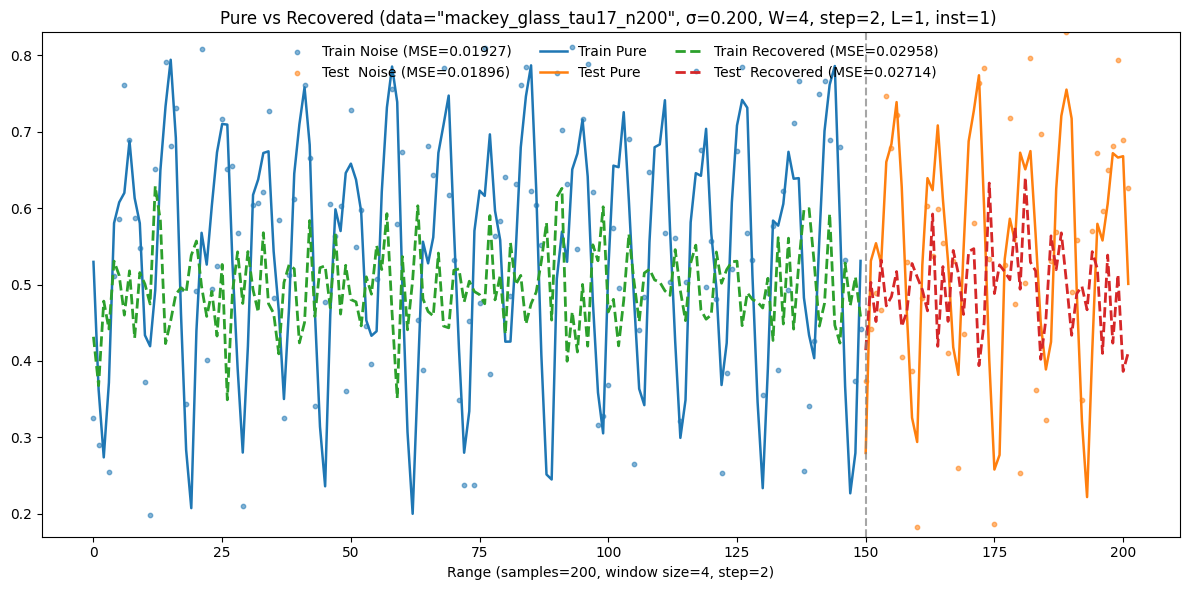

[Series-avg] TRAIN: noise=0.01926807  recovered=0.02958141  Δ=-53.5%
[Series-avg] TEST : noise=0.01895794  recovered=0.02713812  Δ=-43.1%

=== Final plot for L=1, inst=2 ===
Saved plot → aintern\figures\final\4q_2l_2t\L1\plot_4q_2l_2t_L1_inst02.png


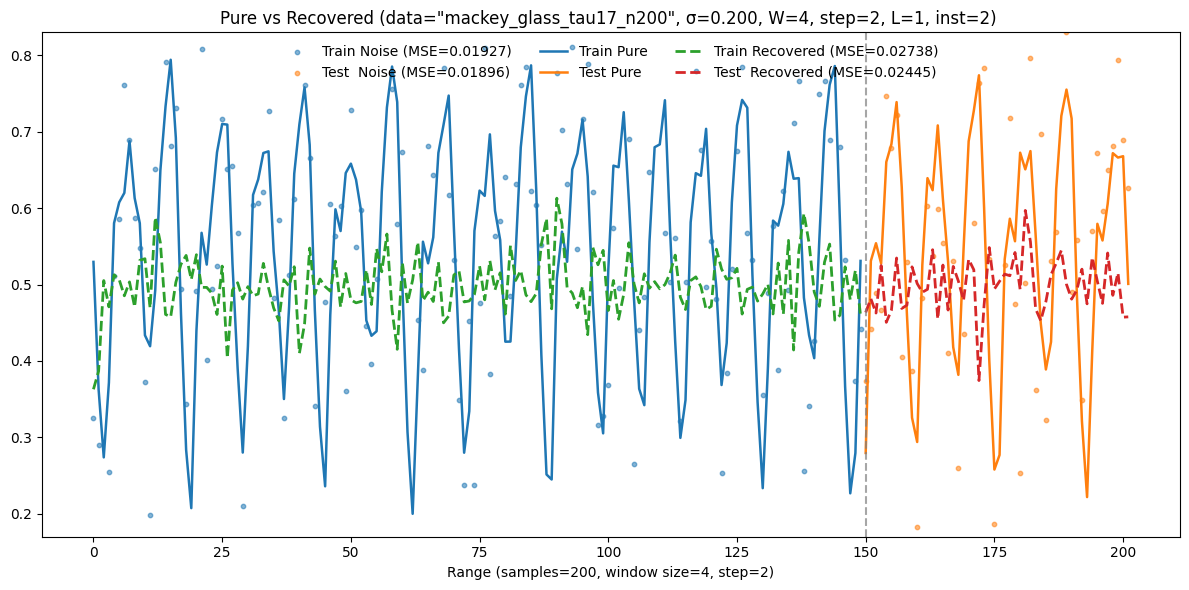

[Series-avg] TRAIN: noise=0.01926807  recovered=0.02737742  Δ=-42.1%
[Series-avg] TEST : noise=0.01895794  recovered=0.02445451  Δ=-29.0%

=== Final plot for L=1, inst=3 ===
Saved plot → aintern\figures\final\4q_2l_2t\L1\plot_4q_2l_2t_L1_inst03.png


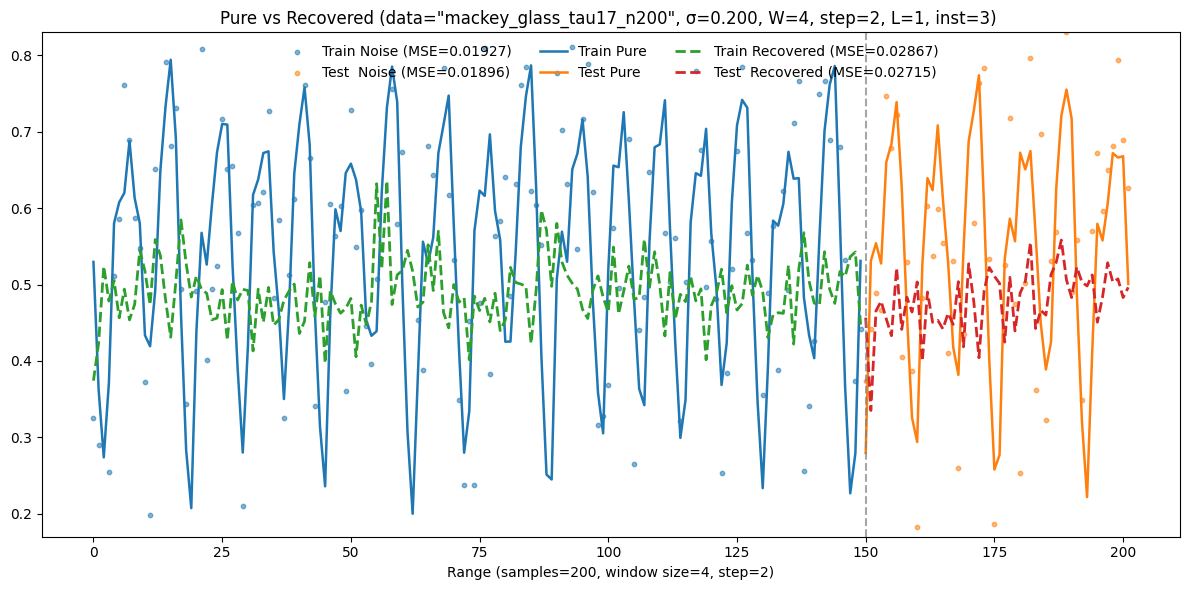

[Series-avg] TRAIN: noise=0.01926807  recovered=0.02867090  Δ=-48.8%
[Series-avg] TEST : noise=0.01895794  recovered=0.02715490  Δ=-43.2%

=== Final plot for L=1, inst=4 ===
Saved plot → aintern\figures\final\4q_2l_2t\L1\plot_4q_2l_2t_L1_inst04.png


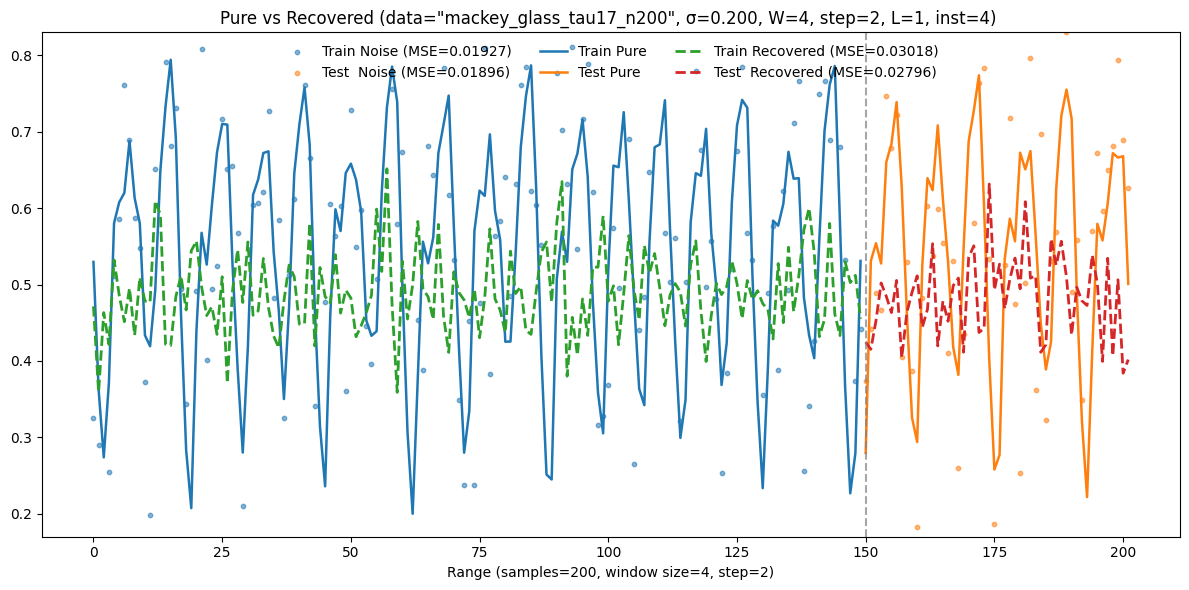

[Series-avg] TRAIN: noise=0.01926807  recovered=0.03017932  Δ=-56.6%
[Series-avg] TEST : noise=0.01895794  recovered=0.02795736  Δ=-47.5%

=== Final plot for L=1, inst=5 ===
Saved plot → aintern\figures\final\4q_2l_2t\L1\plot_4q_2l_2t_L1_inst05.png


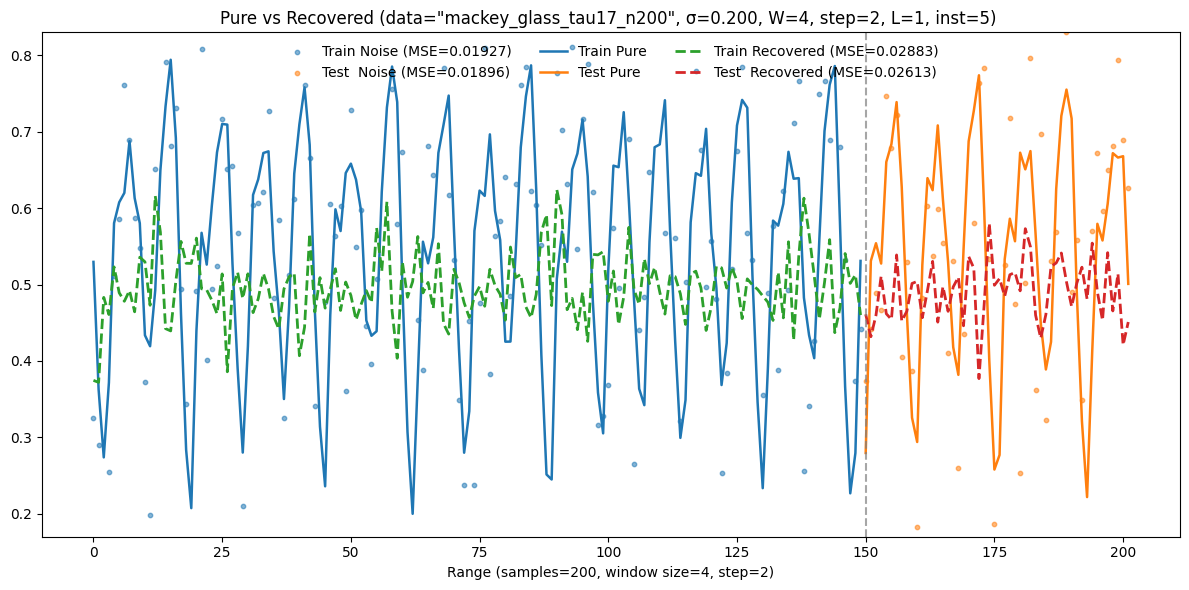

[Series-avg] TRAIN: noise=0.01926807  recovered=0.02883435  Δ=-49.6%
[Series-avg] TEST : noise=0.01895794  recovered=0.02613038  Δ=-37.8%

=== Final plot for L=3, inst=1 ===
Saved plot → aintern\figures\final\4q_2l_2t\L3\plot_4q_2l_2t_L3_inst01.png


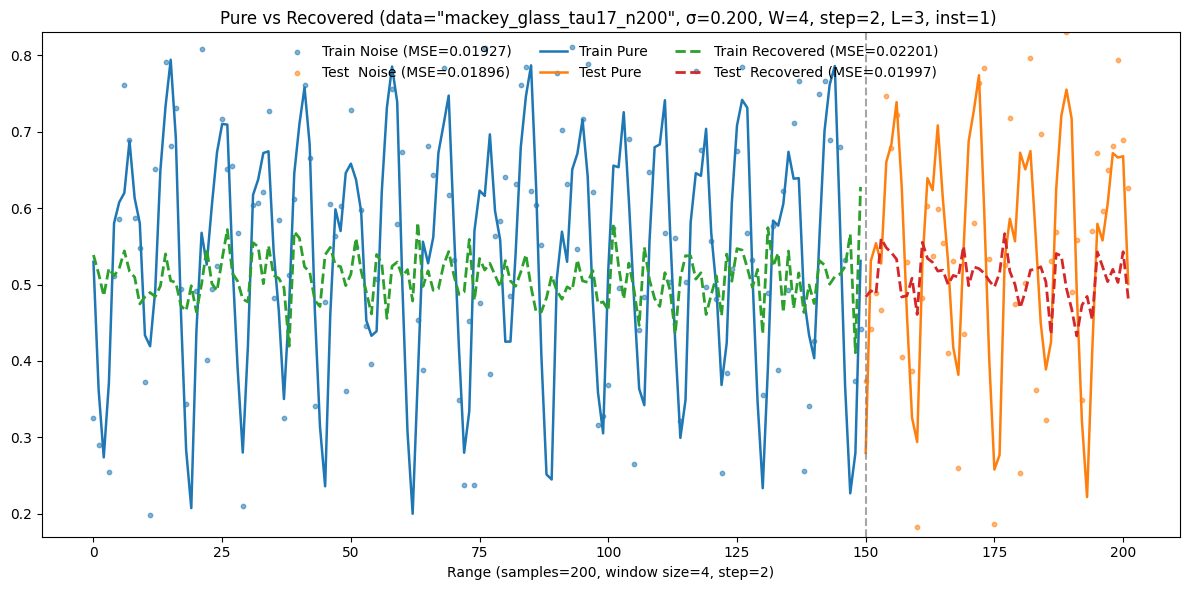

[Series-avg] TRAIN: noise=0.01926807  recovered=0.02200943  Δ=-14.2%
[Series-avg] TEST : noise=0.01895794  recovered=0.01996738  Δ=-5.3%

=== Final plot for L=3, inst=2 ===
Saved plot → aintern\figures\final\4q_2l_2t\L3\plot_4q_2l_2t_L3_inst02.png


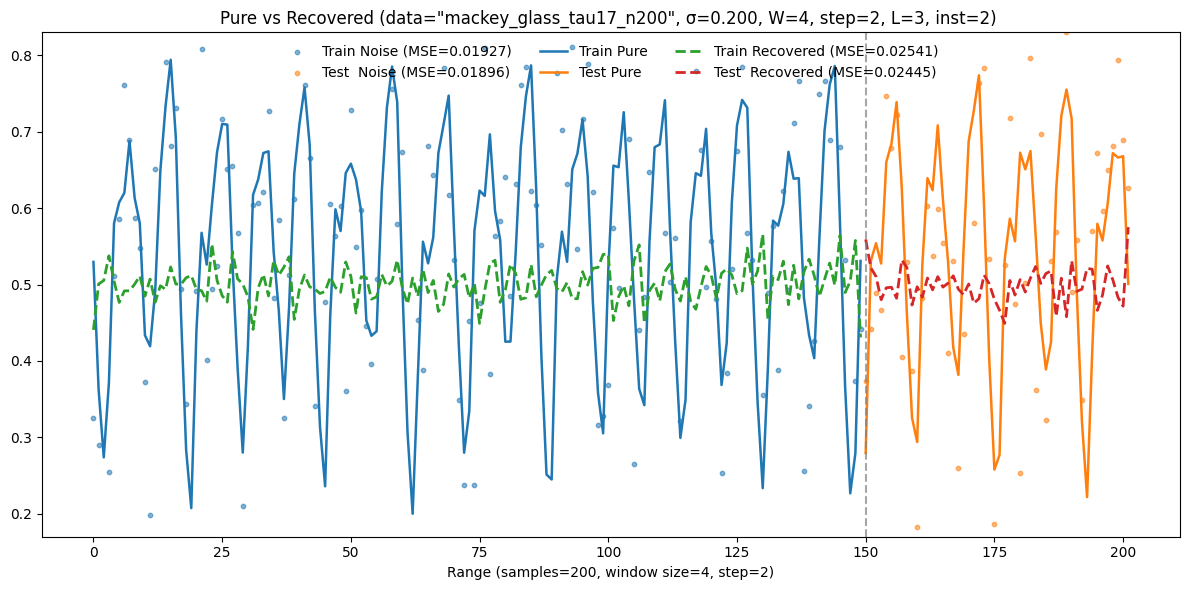

[Series-avg] TRAIN: noise=0.01926807  recovered=0.02541101  Δ=-31.9%
[Series-avg] TEST : noise=0.01895794  recovered=0.02444682  Δ=-29.0%

=== Final plot for L=3, inst=3 ===
Saved plot → aintern\figures\final\4q_2l_2t\L3\plot_4q_2l_2t_L3_inst03.png


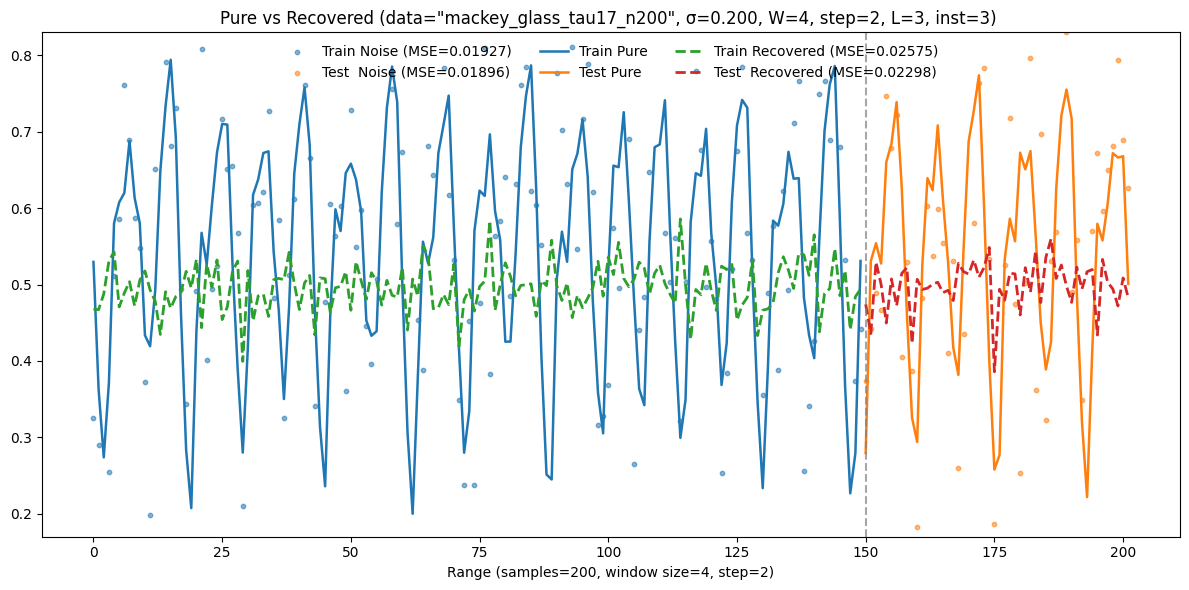

[Series-avg] TRAIN: noise=0.01926807  recovered=0.02574564  Δ=-33.6%
[Series-avg] TEST : noise=0.01895794  recovered=0.02298376  Δ=-21.2%

=== Final plot for L=3, inst=4 ===
Saved plot → aintern\figures\final\4q_2l_2t\L3\plot_4q_2l_2t_L3_inst04.png


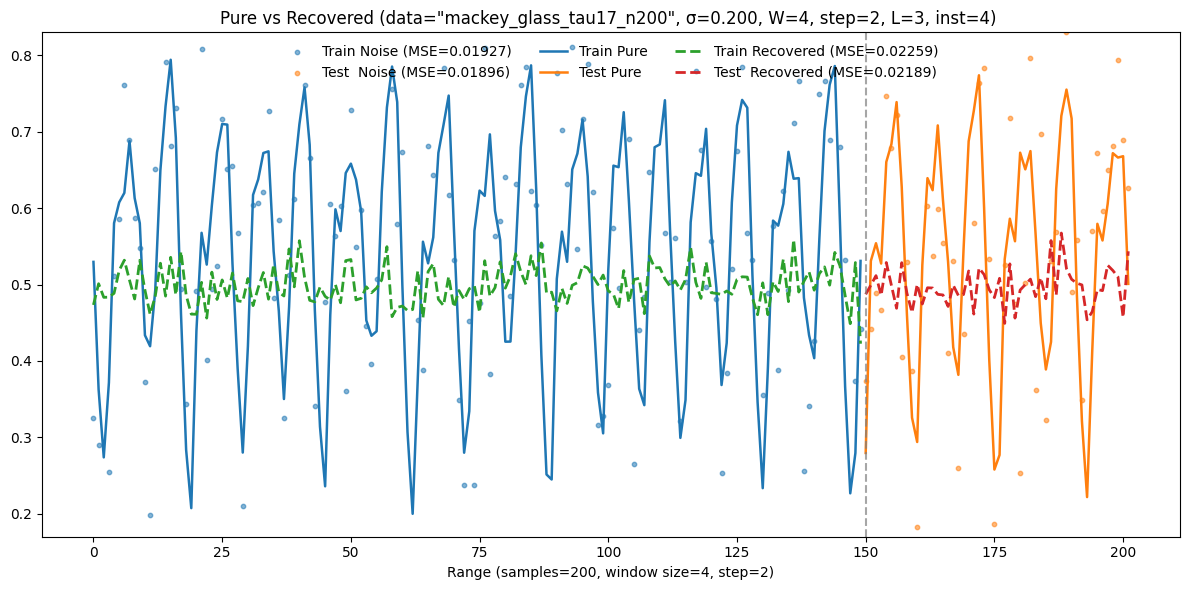

[Series-avg] TRAIN: noise=0.01926807  recovered=0.02258711  Δ=-17.2%
[Series-avg] TEST : noise=0.01895794  recovered=0.02188768  Δ=-15.5%

=== Final plot for L=3, inst=5 ===
Saved plot → aintern\figures\final\4q_2l_2t\L3\plot_4q_2l_2t_L3_inst05.png


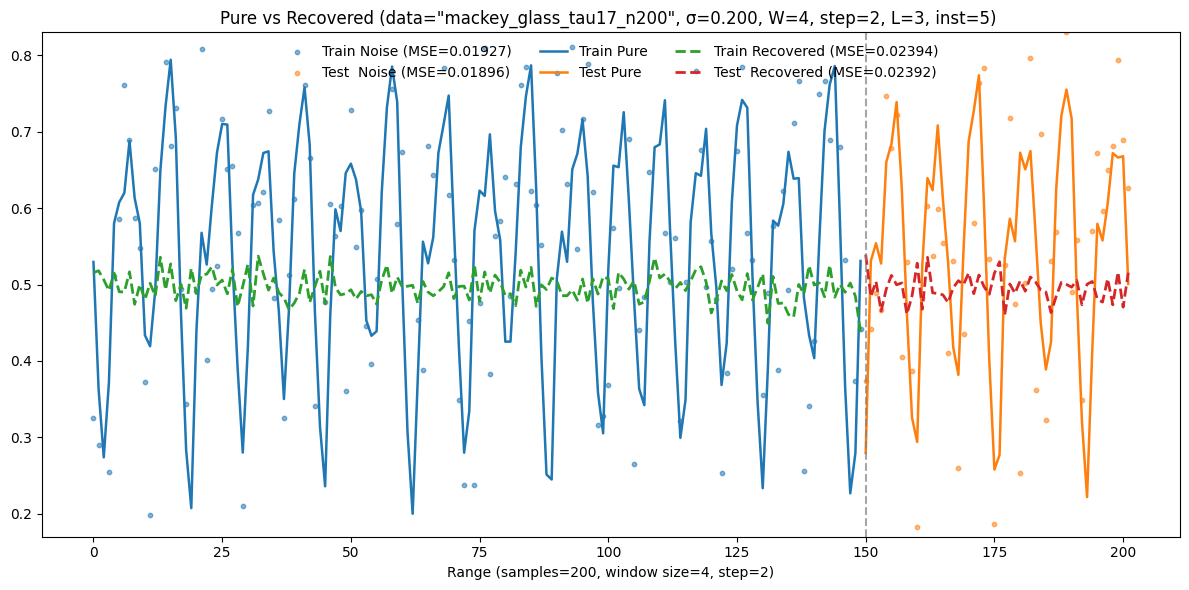

[Series-avg] TRAIN: noise=0.01926807  recovered=0.02393774  Δ=-24.2%
[Series-avg] TEST : noise=0.01895794  recovered=0.02392344  Δ=-26.2%


In [11]:
# ===============================
# Cell 9 — final plots & stats for all instances (rekonstrukcja przez encoder+decoder)
# ===============================
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

ARCH_TAG = f"{n_qubits}q_{n_latent}l_{n_trash}t"
SAVE_PLOTS = True  # set False if you don't want PNGs on disk

def _windows_from_seed(y_vec, sigma, seed):
    y_noisy = ts_add_noise(
        y_vec, noise=sigma, noise_type='normal', clip=False,
        range_low=scale_low, range_high=scale_high, seed=seed
    )
    win_clean = ts_wind_make(y_vec,   wind_size, wind_step)
    win_noisy = ts_wind_make(y_noisy, wind_size, wind_step)
    X_ts = np.array([i*wind_step for i in range(len(win_clean))])
    _, tr_clean, _, te_clean = ts_wind_split(X_ts, win_clean, split)
    _, tr_noisy, _, te_noisy = ts_wind_split(X_ts, win_noisy, split)
    return tr_clean, tr_noisy, te_clean, te_noisy

def _flatten_avg(windows):
    return ts_wind_flatten_avg(np.asarray(windows), wind_step)

def _mse(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.mean((a - b) ** 2))

def _seed_for_run(run, instance_id):
    s3 = run["stage3"]
    if "TEST_SEED_FIXED" in s3:
        return int(s3["TEST_SEED_FIXED"])
    hist = s3.get("hist_train", [])
    return 88_000 + 100*instance_id + (len(hist) - 1 if len(hist) else 0)

# --- Nowa funkcja do rekonstrukcji przez encoder+decoder ---
def reconstruct_windows(params_enc, params_dec, n_layers, windows_noisy):
    dev = qml.device("default.qubit", wires=n_qubits, shots=None)
    @qml.qnode(dev, interface="autograd")
    def circuit(x):
        embed_input(x)
        encoder_ansatz(params_enc, n_layers)
        decoder_ansatz(params_dec, n_layers)
        return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]
    outs = []
    for w in windows_noisy:
        z = circuit(w)
        outs.append(np.array(Z_to_values_autograd(z)))
    return np.stack(outs)

def plot_one(run, save_dir=None, title_note=""):
    inst = int(run["instance_id"])
    L    = int(run["n_layers"])
    phi  = np.array(run["stage1"]["phi"])
    psi  = np.array(run["stage3"]["psi"])

    seed = _seed_for_run(run, inst)

    tr_c, tr_n, te_c, te_n = _windows_from_seed(y, EVAL_SIGMA, seed)
    # --- Rekonstrukcja przez encoder+decoder ---
    tr_rec = reconstruct_windows(psi, phi, L, tr_n)
    te_rec = reconstruct_windows(psi, phi, L, te_n)

    tr_pure = _flatten_avg(tr_c);  te_pure = _flatten_avg(te_c)
    tr_noi  = _flatten_avg(tr_n);  te_noi  = _flatten_avg(te_n)
    tr_hat  = _flatten_avg(tr_rec);te_hat  = _flatten_avg(te_rec)

    mse_tr_noise = _mse(tr_pure, tr_noi)
    mse_te_noise = _mse(te_pure, te_noi)
    mse_tr_hat   = _mse(tr_pure, tr_hat)
    mse_te_hat   = _mse(te_pure, te_hat)

    x_tr = np.arange(len(tr_pure)); x_te = np.arange(len(tr_pure), len(tr_pure)+len(te_pure))
    x_split = len(tr_pure)

    plt.figure(figsize=(12, 6))
    plt.scatter(x_tr, tr_noi, s=10, alpha=0.55, label=f"Train Noise (MSE={mse_tr_noise:0.5f})")
    plt.scatter(x_te, te_noi, s=10, alpha=0.55, label=f"Test  Noise (MSE={mse_te_noise:0.5f})")
    plt.plot(x_tr, tr_pure, linewidth=1.8, label="Train Pure")
    plt.plot(x_te, te_pure, linewidth=1.8, label="Test Pure")
    plt.plot(x_tr, tr_hat, linestyle="--", linewidth=2.0, label=f"Train Recovered (MSE={mse_tr_hat:0.5f})")
    plt.plot(x_te, te_hat, linestyle="--", linewidth=2.0, label=f"Test  Recovered (MSE={mse_te_hat:0.5f})")
    plt.axvline(x_split, color="grey", linestyle="--", alpha=0.7)
    plt.ylim(scale_low - 0.05*(scale_high - scale_low), scale_high + 0.05*(scale_high - scale_low))
    plt.xlabel(f'Range (samples={len(y)}, window size={wind_size}, step={wind_step})')
    plt.title(f'Pure vs Recovered (data=\"{DATA_ID}\", σ={EVAL_SIGMA:.3f}, '
              f'W={wind_size}, step={wind_step}, L={L}, inst={inst}) {title_note}')
    plt.legend(loc="upper center", ncol=3, frameon=False)
    plt.tight_layout()

    if SAVE_PLOTS and save_dir:
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        out_png = Path(save_dir) / f"plot_{ARCH_TAG}_L{L}_inst{inst:02d}.png"
        plt.savefig(out_png, dpi=200, bbox_inches="tight", pad_inches=0.08)
        print(f"Saved plot → {out_png}")
    plt.show()

    dtr = 100*(1 - mse_tr_hat/max(mse_tr_noise,1e-12))
    dte = 100*(1 - mse_te_hat/max(mse_te_noise,1e-12))
    print(f"[Series-avg] TRAIN: noise={mse_tr_noise:0.8f}  recovered={mse_tr_hat:0.8f}  Δ={dtr:+.1f}%")
    print(f"[Series-avg] TEST : noise={mse_te_noise:0.8f}  recovered={mse_te_hat:0.8f}  Δ={dte:+.1f}%")

# -- Run plots for every trained (instance, L)
for L in LAYER_OPTIONS:
    for inst in INSTANCE_IDS:
        if any(r["n_layers"] == L and r["instance_id"] == inst for r in ALL_RUNS):
            run = next(r for r in ALL_RUNS if r["n_layers"] == L and r["instance_id"] == inst)
            print(f"\n=== Final plot for L={L}, inst={inst} ===")
            plot_one(run, save_dir=f"{FIGURES_PATH}/final/{ARCH_TAG}/L{L}")

In [12]:
# ===============================
# Cell A — Circuit renderer (Stage 1: adjoint decoder)
# ===============================
def render_and_save_stage1_decoder(
    L, phi_vec, save_dir, inst,
    style="pennylane", level="device", fname_prefix="stage1_decoder"
):
    """
    Rysuje obwód: embed_input → adjoint_decoder_ansatz(phi) → pomiar Z.
    """
    main_wires = list(range(n_qubits))
    dev = qml.device("default.qubit", wires=main_wires, shots=None)
    theta_phi = pnp.array(phi_vec, requires_grad=False)

    @qml.qnode(dev)
    def circuit_for_draw(x_in):
        embed_input(x_in)
        adjoint_decoder_ansatz(theta_phi, L)

    x_dummy = pnp.zeros(wind_size, dtype=float)
    qml.drawer.use_style(style)
    fig, ax = qml.draw_mpl(circuit_for_draw, decimals=2, level=level)(x_dummy)

    save_dir = Path(save_dir); save_dir.mkdir(parents=True, exist_ok=True)
    out_png = save_dir / f"{fname_prefix}_L{L}_inst{int(inst):02d}.png"
    fig.savefig(out_png, dpi=220, bbox_inches="tight", pad_inches=0.1)
    plt.close(fig)
    return out_png

# ===============================
# Cell A — Circuit renderer (Stage 3: encoder + decoder)
# ===============================
def render_and_save_stage3_encoder_decoder(
    L, phi_vec, psi_vec, save_dir, inst,
    style="pennylane", level="device", fname_prefix="stage3_encdec"
):
    """
    Rysuje obwód: embed_input → encoder_ansatz(psi) → decoder_ansatz(phi) → pomiar Z.
    """
    main_wires = list(range(n_qubits))
    dev = qml.device("default.qubit", wires=main_wires, shots=None)
    theta_phi = pnp.array(phi_vec, requires_grad=False)
    theta_psi = pnp.array(psi_vec, requires_grad=False)

    @qml.qnode(dev)
    def circuit_for_draw(x_in):
        embed_input(x_in)
        encoder_ansatz(theta_psi, L)
        adjoint_decoder_ansatz(theta_phi, L)

    x_dummy = pnp.zeros(wind_size, dtype=float)
    qml.drawer.use_style(style)
    fig, ax = qml.draw_mpl(circuit_for_draw, decimals=2, level=level)(x_dummy)

    save_dir = Path(save_dir); save_dir.mkdir(parents=True, exist_ok=True)
    out_png = save_dir / f"{fname_prefix}_L{L}_inst{int(inst):02d}.png"
    fig.savefig(out_png, dpi=220, bbox_inches="tight", pad_inches=0.1)
    plt.close(fig)
    return out_png

def render_and_save_circuit(
    L, phi_vec, psi_vec, save_dir, inst,
    style="pennylane", level="device", fname_prefix="circuit"
):
    """
    Rysuje obwód: embed_input → encoder_ansatz(psi) → decoder_ansatz(phi) → pomiar Z.
    """
    main_wires = list(range(n_qubits))
    dev = qml.device("default.qubit", wires=main_wires, shots=None)

    theta_phi = pnp.array(phi_vec, requires_grad=False)
    theta_psi = pnp.array(psi_vec, requires_grad=False)

    @qml.qnode(dev)
    def circuit_for_draw(x_in):
        embed_input(x_in)
        encoder_ansatz(theta_psi, L)
        decoder_ansatz(theta_phi, L)
        return [qml.expval(qml.PauliZ(w)) for w in main_wires]

    x_dummy = pnp.zeros(wind_size, dtype=float)
    qml.drawer.use_style(style)
    fig, ax = qml.draw_mpl(circuit_for_draw, decimals=2, level=level)(x_dummy)

    save_dir = Path(save_dir); save_dir.mkdir(parents=True, exist_ok=True)
    out_png = save_dir / f"{fname_prefix}_L{L}_inst{int(inst):02d}.png"
    fig.savefig(out_png, dpi=220, bbox_inches="tight", pad_inches=0.1)
    plt.close(fig)
    return out_png

In [13]:
# ===============================
# Cell B — Save φ/ψ + circuit PNGs + CSVs (dla encoder+decoder)
# ===============================
import json, csv, time, os
from pathlib import Path
import numpy as np
import pandas as pd

def ensure_dir(p: str | Path) -> Path:
    p = Path(p); p.mkdir(parents=True, exist_ok=True); return p

def arch_tag():
    return f"{n_qubits}q_{n_latent}l_{n_trash}t"

def inst_fname(L, inst):
    return f"inst{int(inst):02d}_L{int(L)}"

def _windows_from_seed(y_vec, sigma, seed):
    y_noisy = ts_add_noise(
        y_vec, noise=sigma, noise_type='normal', clip=False,
        range_low=scale_low, range_high=scale_high, seed=seed
    )
    win_clean = ts_wind_make(y_vec, wind_size, wind_step)
    win_noisy = ts_wind_make(y_noisy, wind_size, wind_step)
    X_ts = np.array([i*wind_step for i in range(len(win_clean))])
    _, tr_clean, _, te_clean = ts_wind_split(X_ts, win_clean, split)
    _, tr_noisy, _, te_noisy = ts_wind_split(X_ts, win_noisy, split)
    return tr_clean, tr_noisy, te_clean, te_noisy

def _flatten_avg(windows):
    return ts_wind_flatten_avg(np.asarray(windows), wind_step)

def _mse(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.mean((a - b) ** 2))

def _choose_eval_seed(run, instance_id):
    s3 = run["stage3"]
    if "TEST_SEED_FIXED" in s3 and s3["TEST_SEED_FIXED"] is not None:
        return int(s3["TEST_SEED_FIXED"])
    eplen = len(s3.get("hist_train_win_mse", []))
    return 88_000 + 100*instance_id + max(eplen - 1, 0)

ROOT = ensure_dir("qae_runs")
DATA_ROOT = ensure_dir(ROOT / DATA_ID)
ARCH_ROOT = ensure_dir(DATA_ROOT / arch_tag())
dir_L = {L: ensure_dir(ARCH_ROOT / f"L{int(L)}") for L in set(LAYER_OPTIONS)}

CSV_RUNS   = ARCH_ROOT / "metrics_by_run.csv"
CSV_SUMMARY= ARCH_ROOT / "summary_by_layer.csv"

RUNS_HEADER = [
    "dataset","arch","instance_id","layer",
    "window_size","step","sigma_eval",
    "mse_train_noise","mse_train_recovered","delta_train_pct",
    "mse_test_noise","mse_test_recovered","delta_test_pct",
    "s1_best_train_cost","timestamp","bundle_json"
]
if not CSV_RUNS.exists():
    with open(CSV_RUNS, "w", newline="", encoding="utf-8") as f:
        csv.writer(f).writerow(RUNS_HEADER)

rows = []
for run in ALL_RUNS:
    inst = int(run["instance_id"])
    L    = int(run["n_layers"])
    phi  = np.array(run["stage1"]["phi"])
    psi  = np.array(run["stage3"]["psi"])

    np.save(dir_L[L] / f"phi_{inst_fname(L, inst)}.npy", phi)
    np.save(dir_L[L] / f"psi_{inst_fname(L, inst)}.npy", psi)

    seed_eval = _choose_eval_seed(run, inst)
    tr_c, tr_n, te_c, te_n = _windows_from_seed(y, EVAL_SIGMA, seed_eval)

    # Rekonstrukcja przez encoder+decoder
    def reconstruct_windows(params_enc, params_dec, n_layers, windows_noisy):
        dev = qml.device("default.qubit", wires=n_qubits, shots=None)
        @qml.qnode(dev, interface="autograd")
        def circuit(x):
            embed_input(x)
            encoder_ansatz(params_enc, n_layers)
            decoder_ansatz(params_dec, n_layers)
            return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]
        outs = []
        for w in windows_noisy:
            z = circuit(w)
            outs.append(np.array(Z_to_values_autograd(z)))
        return np.stack(outs)

    tr_hat_w = reconstruct_windows(psi, phi, L, tr_n)
    te_hat_w = reconstruct_windows(psi, phi, L, te_n)

    tr_pure = _flatten_avg(tr_c);  te_pure = _flatten_avg(te_c)
    tr_noi  = _flatten_avg(tr_n);  te_noi  = _flatten_avg(te_n)
    tr_hat  = _flatten_avg(tr_hat_w); te_hat = _flatten_avg(te_hat_w)

    mse_tr_noise = _mse(tr_pure, tr_noi)
    mse_te_noise = _mse(te_pure, te_noi)
    mse_tr_hat   = _mse(tr_pure, tr_hat)
    mse_te_hat   = _mse(te_pure, te_hat)

    d_tr = 100.0 * (1.0 - mse_tr_hat / max(mse_tr_noise, 1e-12))
    d_te = 100.0 * (1.0 - mse_te_hat / max(mse_te_noise, 1e-12))

    # Zapisz PNG obwodu encoder+decoder
    png_path = render_and_save_circuit(L, phi, psi, save_dir=ARCH_ROOT, inst=inst,
                                       style="pennylane", level="device",
                                       fname_prefix="circuit")

    bundle = {
        "schema": {"name": "half_qae_bundle", "version": "1.0"},
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "dataset": {
            "id": DATA_ID,
            "scale_low":  float(scale_low),
            "scale_high": float(scale_high),
            "window_size": int(wind_size),
            "window_step": int(wind_step),
            "split": float(split),
        },
        "run": {
            "instance_id": inst,
            "layer": L,
            "sigma_eval": float(EVAL_SIGMA),
            "test_seed_fixed": int(run["stage3"].get("TEST_SEED_FIXED", seed_eval)),
        },
        "environment": {
            "device": "default.qubit",
            "reset_mode": "none",
        },
        "architecture": {
            "n_qubits": int(n_qubits),
            "n_latent": int(n_latent),
            "n_trash":  int(n_trash),
        },
        "parameters": {
            "phi": phi.tolist(),
            "psi": psi.tolist(),
        },
        "metrics_series": {
            "mse_train_noise": mse_tr_noise,
            "mse_train_recovered": mse_tr_hat,
            "delta_train_pct": d_tr,
            "mse_test_noise": mse_te_noise,
            "mse_test_recovered": mse_te_hat,
            "delta_test_pct": d_te,
        }
    }
    bundle_path = dir_L[L] / f"bundle_{inst_fname(L, inst)}.json"
    with open(bundle_path, "w", encoding="utf-8") as f:
        json.dump(bundle, f, indent=2)

    rows.append([
        DATA_ID, arch_tag(), inst, L,
        int(wind_size), int(wind_step), float(EVAL_SIGMA),
        mse_tr_noise, mse_tr_hat, d_tr,
        mse_te_noise, mse_te_hat, d_te,
        float(run["stage1"].get("best_train", np.nan)),
        bundle["timestamp"],
        str(bundle_path)
    ])

if rows:
    df_new = pd.DataFrame(rows, columns=RUNS_HEADER)
    if CSV_RUNS.exists():
        df_old = pd.read_csv(CSV_RUNS)
        key_cols = ["dataset","arch","instance_id","layer"]
        df_old = df_old.drop_duplicates(subset=key_cols, keep="last")
        df_new = pd.concat([df_old, df_new], ignore_index=True)
        df_new = df_new.drop_duplicates(subset=key_cols, keep="last")
    df_new.to_csv(CSV_RUNS, index=False)
    print(f"Updated per-run metrics → {CSV_RUNS}")

if Path(CSV_RUNS).exists():
    df = pd.read_csv(CSV_RUNS)
    summary = (df
        .groupby("layer", as_index=True)
        .agg(
            runs=("instance_id","count"),
            mse_test_noise_mean=("mse_test_noise","mean"),
            mse_test_recovered_mean=("mse_test_recovered","mean"),
            delta_test_pct_mean=("delta_test_pct","mean"),
        )
    )
    summary.to_csv(CSV_SUMMARY)
    print(f"Saved per-layer summary → {CSV_SUMMARY}")

print(f"Artifacts saved under → {ARCH_ROOT}")

Updated per-run metrics → qae_runs\mackey_glass_tau17_n200\4q_2l_2t\metrics_by_run.csv
Saved per-layer summary → qae_runs\mackey_glass_tau17_n200\4q_2l_2t\summary_by_layer.csv
Artifacts saved under → qae_runs\mackey_glass_tau17_n200\4q_2l_2t
